# Mobility in Tokyo

- Data source: NTT DoCoMo's [Mobile Kukan Toukei](https://mobaku.jp/)
    - “Mobile Kukan Toukei” is a trademark of NTT DOCOMO, INC.
    - NTT DOCOMO’s “Mobile Kukan Toukei” services are only available to subscribers in Japan.


In [1]:
# This code should run as a separate .py file in a command line.
# Running it in Notebook is *very* slow

import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import pickle

data_dir = "/mnt/f/Users/Hiroshi/Desktop/DoCoMo/"
data_dir = "f:/Users/Hiroshi/Desktop/DoCoMo/"
cache_dir = data_dir + "cache/"
plot_dir = "plots/"
debug = True

def read_cluster(cluster_fn):
    pred = None
    if os.path.exists(cluster_fn):
        with open(cluster_fn, 'rb') as f:
            pred = pickle.load(f)
        print('Using saved cluster', cluster_fn)
    return pred

cluster = read_cluster(cache_dir + 'cluster.pickle')     

patterns = {"00000":["area"], 
            "00000_c": ["area"],
            "00001":["area", "age", "gender"],
            "00001_c":["area", "age", "gender"],
            "00002_c":["area", "residence"],
            "00003":["residence"]}

tables = {}

def read_cache(pattern):
    fn = cache_dir + pattern + ".pickle"
    if os.path.exists(fn):
        with open(fn, 'rb') as f:
            return pickle.load(f)
    else:
        return None

def read_hourly_data(pattern, d, h):
    index_cols = patterns[pattern]
    d_str = d.strftime("%Y%m%d")
    d_h = d + pd.Timedelta('{} hours'.format(h))
    fn = data_dir + "s3/realtime/{}/clipped_mesh_pop_{}{:02d}00_{}.csv.zip" \
      .format(d_str, d_str, h, pattern[0:5])
    print("Reading {}...".format(fn))
    if os.path.exists(fn):
        with open(fn, 'rb') as f:
            hourly = pd.read_csv(fn, usecols= index_cols + ["population"], dtype={"area": str})
            hourly = hourly.set_index(index_cols)
            hourly.rename(columns={"population": d_h}, inplace=True)
    else:
        hourly = pd.DataFrame(columns=index_cols + ["population"])
        hourly.set_index(index_cols, inplace=True)
        hourly.rename(columns={"population": d_h}, inplace=True)
    return hourly

def add_hour(pattern, t_1, t, m):
    index_cols = patterns[pattern]
    if debug:
        print("t-1")
        display(t_1)
        print("t")
        display(t)
    # 1. Calculate Norm
    df = t_1.merge(t, how='outer', left_index=True, right_index=True).fillna(0)
    if debug:
        print("After merge")
        display(df)
    norm = df.diff(axis=1).abs()
    norm.reset_index(inplace=True)
    norm.set_index(index_cols[0], inplace=True)
    if debug:
        print("Norm")
        display(norm)
    # 2. Join category
    df = norm.merge(cluster, how='right', left_index=True, right_index=True).fillna(0)
    df.rename(columns={0:"cluster"}, inplace=True)
    if debug:
        print("With category")
        display(df)
    # 3. Group them
    df = df.groupby(["cluster"] + patterns[pattern][1:]).mean()
    if debug:
        print("Grouped by")
        display(df)
        print("m")
        display(m)
    # 4. Merge it to m
    df = m.merge(df.iloc[:,1], how='outer', left_index=True, right_index=True).fillna(0)
    if debug:
        print("mobility_by_category")
        display(df)
    return df

def update_cache(pattern, end_date=None):
    mobility_by_cat = read_cache(pattern)
    if mobility_by_cat is None:        
        start_date = pd.to_datetime("2020-01-01")
        # mobility_by_cat = pd.DataFrame(columns=patterns[pattern] + ["population"])
        # mobility_by_cat = mobility_by_cat .set_index(patterns[pattern])
        # mobility_by_cat.rename(columns={"population": start_date}, inplace=True)
        mobility_by_cat = pd.DataFrame(columns=["cluster"] + patterns[pattern][1:])
        mobility_by_cat.set_index(["cluster"] + patterns[pattern][1:], inplace=True)
        # print(mobility_by_cat)
    else:
        start_date = pd.to_datetime(mobility_by_cat.columns[-1]) + pd.Timedelta('1 days')
    if end_date is None:
        end_date = pd.Timestamp.today() - pd.Timedelta('1 days')
    dates_to_add = pd.date_range(start=start_date.date(), end=end_date)
    # print(dates_to_add)
    hourly_last = read_hourly_data(pattern, dates_to_add[0] - pd.Timedelta('1 day'), 23) # 前日の23時
    for d in dates_to_add:
        for h in range(24):
            hourly = read_hourly_data(pattern, d, h)
            mobility_by_cat = add_hour(pattern, hourly_last, hourly, mobility_by_cat)
            hourly_last = hourly
            if debug and h > 1:
                return
               
    with open(cache_dir + pattern + ".pickle", 'wb') as f:
        pickle.dump(mobility_by_cat, f)

def read_table(pattern):
    update_cache(pattern)
    tables[pattern] = read_cache(pattern)

# update_cache("00003", end_date=pd.to_datetime("2020-01-01"))

# update_cache("00000", end_date=pd.to_datetime("2020-02-29"))
# t = read_hourly_data("00000", pd.to_datetime("2020-01-01"), 0)
# pred.merge(t, left_index=True, right_index=True, how='left').groupby(0).sum()
print('Done')

Using saved cluster f:/Users/Hiroshi/Desktop/DoCoMo/cache/cluster.pickle
Done


### Plot mobility by cluster and investigate the anomaly
- Cluster 3 is night areas (e.g., Shinjuku, Shibuya)
    - '533935952' '533945254' '533945263' '533945361' '533945764' '533946013'
- It has anomaly on Feb. 19, at 5pm and 8pm
    - Especially Shinjuku and Ikebukuro. The cell populations are 10,000 ~ 20,000 higher than normal

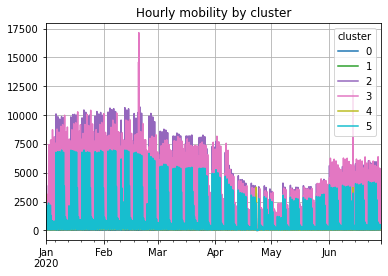

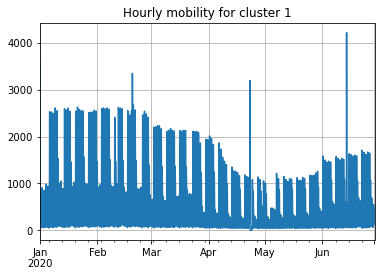

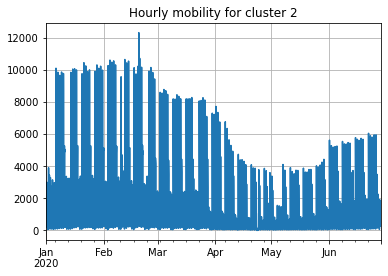

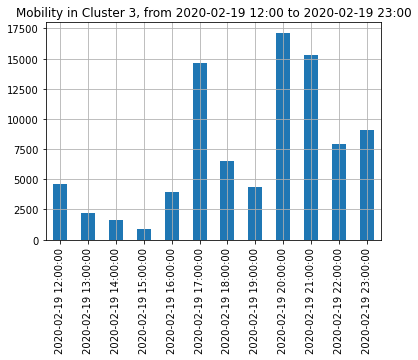

In [2]:
t = read_cache("00000_c")

t.T.plot(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Hourly mobility by cluster")
plt.show()

t.loc[1,:].T.plot(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Hourly mobility for cluster 1")
plt.show()

t.loc[2,:].T.plot(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Hourly mobility for cluster 2")
plt.show()

t.loc[3,"2020-02-19 12:00":"2020-02-19 23:00"].T.plot.bar(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Mobility in Cluster 3, from 2020-02-19 12:00 to 2020-02-19 23:00")
plt.show()

Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191600_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191700_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191800_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191900_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002192000_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002192100_00001.csv.zip...


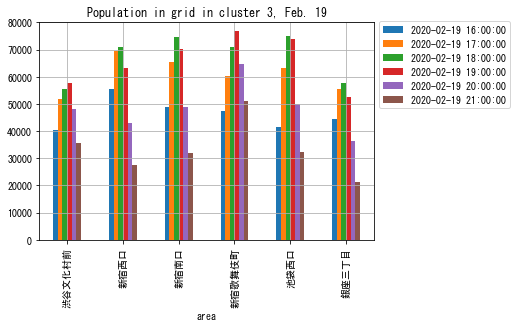

Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121600_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121700_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121800_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121900_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002122000_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002122100_00001.csv.zip...


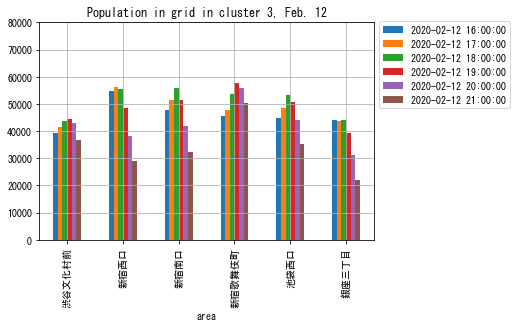

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)

# Check to see which grid cell has the anomaly
cluster3 = cluster[cluster[0] == 3]
cellnames = {'533935952':"渋谷文化村前",
             '533945254':"新宿西口",
             '533945263':"新宿南口",
             '533945361':"新宿歌舞伎町",
             '533945764':"池袋西口",
             '533946013':"銀座三丁目"
            }
#print(cellnames.values())

#print(cluster3.index.values)
# print('533935952' in cluster3.index)

def read_hourly_data_in_cluster(pattern, date, hour, cluster):
    df = read_hourly_data(pattern, date, hour).reset_index()
    df = df[df.area.isin(cluster)]
    return df



rows = [read_hourly_data_in_cluster("00001", pd.to_datetime("2020-02-19"), h, cluster3.index.values) \
           .groupby("area").sum().iloc[:,2]
           for h in range(16,22)
          ]
t = pd.DataFrame(rows).rename(columns=cellnames)
# display(t)
t.T.plot.bar(grid=True, ylim=[0, 80000]).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.title("Population in grid in cluster 3, Feb. 19")
plt.show()

# for comparison, show the dame data for one week before
rows = [read_hourly_data_in_cluster("00001", pd.to_datetime("2020-02-12"), h, cluster3.index.values) \
           .groupby("area").sum().iloc[:,2]
           for h in range(16,22)
          ]
t = pd.DataFrame(rows).rename(columns=cellnames)
# display(t)
t.T.plot.bar(grid=True, ylim=[0, 80000]).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.title("Population in grid in cluster 3, Feb. 12")
plt.show()


# feb19_20 = feb19_20.merge(cluster, how="inner", left_on="area", right_index=True).rename(columns={0:"cluster"})
#feb19_20[feb19_20.cluster==3].groupby("area").sum()
#feb19_20.groupby("area").sum()

Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191600_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191700_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191800_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191900_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002192000_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002192100_00001.csv.zip...


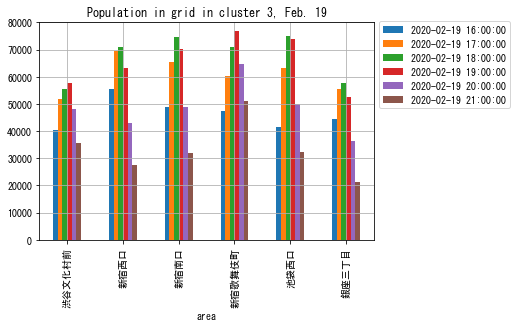

Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121600_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121700_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121800_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121900_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002122000_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002122100_00001.csv.zip...


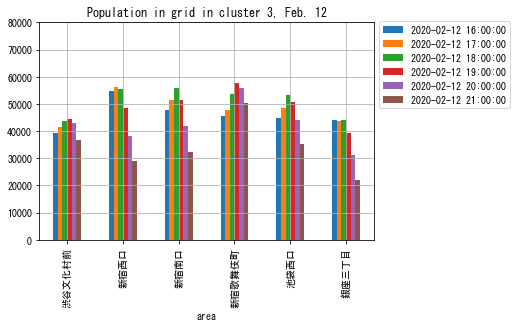

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)

# Check to see which grid cell has the anomaly
cluster3 = cluster[cluster[0] == 3]
cellnames = {'533935952':"渋谷文化村前",
             '533945254':"新宿西口",
             '533945263':"新宿南口",
             '533945361':"新宿歌舞伎町",
             '533945764':"池袋西口",
             '533946013':"銀座三丁目"
            }
#print(cellnames.values())

#print(cluster3.index.values)
# print('533935952' in cluster3.index)

def read_hourly_data_in_cluster(pattern, date, hour, cluster):
    df = read_hourly_data(pattern, date, hour).reset_index()
    df = df[df.area.isin(cluster)]
    return df



rows = [read_hourly_data_in_cluster("00001", pd.to_datetime("2020-02-19"), h, cluster3.index.values) \
           .groupby("area").sum().iloc[:,2]
           for h in range(16,22)
          ]
t = pd.DataFrame(rows).rename(columns=cellnames)
# display(t)
t.T.plot.bar(grid=True, ylim=[0, 80000]).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.title("Population in grid in cluster 3, Feb. 19")
plt.show()

# for comparison, show the dame data for one week before
rows = [read_hourly_data_in_cluster("00001", pd.to_datetime("2020-02-12"), h, cluster3.index.values) \
           .groupby("area").sum().iloc[:,2]
           for h in range(16,22)
          ]
t = pd.DataFrame(rows).rename(columns=cellnames)
# display(t)
t.T.plot.bar(grid=True, ylim=[0, 80000]).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.title("Population in grid in cluster 3, Feb. 12")
plt.show()


# feb19_20 = feb19_20.merge(cluster, how="inner", left_on="area", right_index=True).rename(columns={0:"cluster"})
#feb19_20[feb19_20.cluster==3].groupby("area").sum()
#feb19_20.groupby("area").sum()

In [5]:
%load_ext autotime


# Mobility Time Series by Category
window = 7
yesterday = pd.Timestamp.today().date()-pd.Timedelta('{} days'.format(window // 2 + 1))
reference_dates = pd.to_datetime(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-28', '2020-05-26', str(yesterday)])

def plot_mobility_by_cat(df, cat, reference_dates, cluster=None, 
                         window=7, cmap=plt.get_cmap("tab10"),
                         publish=False):
    cat_str = ",".join(cat)
    if cluster is not None:
        df = df[list(map(lambda x: x[0] == cluster, df.index))]   # Select specified cluster
    if debug:
        print(cat, reference_dates, window)
        display(df)
    mobility_by_cat = df.groupby(cat).sum()
    if debug:
        print("Groupby", cat)
        display(mobility_by_cat)
    mobility_by_cat = mobility_by_cat.resample('1D', axis=1).mean() \
                    .rolling(window, center=True, axis=1).mean() \
                    .loc[:, '2020-2-1':]
    if debug:
        print("Resampled")
        display(mobility_by_cat)
    if cluster is not None:
        title = "Daily Mobility of cluster {} by {} ({} day rolling ave)".format(cluster, cat_str, window)
    else:
        title = "Daily Mobility by {} ({} day rolling ave)".format(cat_str, window)
    maxy = mobility_by_cat.max()
    # mobility_by_cat.T.plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
    mobility_by_cat.T.plot(title=title, cmap=cmap, grid=True)
    plt.ylabel("Mean Hourly Mobility")
    plt.xlabel("Center date of {} day window".format(window))
    plt.legend(loc="lower left")
    plt.vlines(reference_dates, 0, maxy, "red", linestyles='dashed')
    if publish:
        plt.savefig(plot_dir + title)
    plt.show()

    # mobility reduction rate by cluster
    m = mobility_by_cat.loc[:,reference_dates]
    for t in range(1, len(reference_dates)):
        m[reference_dates[t]] =  m[reference_dates[t]] / m[reference_dates[0]] - 1.0
    if debug:
        display(m.drop(columns=reference_dates[0]).T)
    m.drop(columns=reference_dates[0]).T.plot.bar(cmap=cmap, grid=True)
    if cluster is not None:
        title = "Mobility Reduction Rate of cluster {} by {} (relative to {})".format(cluster, cat_str, reference_dates[0].date())
    else:
        title = "Mobility Reduction Rate by {} (relative to {})".format(cat_str, reference_dates[0].date())
    plt.title(title)
    plt.ylabel("Mobility Reduction Rate")
    plt.xlabel("Center date of {} day window".format(window))
    plt.legend(loc="lower left")
    plt.xticks(range(len(reference_dates[1:])), reference_dates[1:].date, rotation=0)
    if publish:
        plt.savefig(plot_dir + title)
    plt.show()
    return

def plot_mobility_by_grid(df, cells, reference_dates, 
                         window=7, cmap=plt.get_cmap("tab10"),
                         publish=False):
    if debug:
        print(cells, reference_dates, window)
        display(df)
    # cells_df = pd.DataFrame(index=[int(x) for x in list(cells.keys())])
    cells_df = pd.DataFrame(index=list(cells.keys()))
    mobility_by_cell = df.merge(cells_df, how="right", left_index=True, right_index=True)
    if debug:
        print("Merge", list(cells.keys()))
        display(mobility_by_cell)
    mobility_by_cell = mobility_by_cell.resample('1D', axis=1).mean() \
                    .rolling(window, center=True, axis=1).mean() \
                    .loc[:, '2020-2-1':]
    if debug:
        print("Resampled")
        display(mobility_by_cell)
    title = "Daily Mobility by cell ({} day rolling ave)".format(window)
    maxy = mobility_by_cell.max()
    # mobility_by_cat.T.plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
    mobility_by_cell.T.plot(title=title, cmap=cmap, grid=True)
    plt.ylabel("Mean Hourly Mobility")
    plt.xlabel("Center date of {} day window".format(window))
    plt.legend(list(cells.values()), loc="lower left")
    plt.vlines(reference_dates, 0, maxy, "red", linestyles='dashed')
    if publish:
        plt.savefig(plot_dir + title)
    plt.show()

    # mobility reduction rate by cluster
    m = mobility_by_cell.loc[:,reference_dates]
    for t in range(1, len(reference_dates)):
        m[reference_dates[t]] =  m[reference_dates[t]] / m[reference_dates[0]] - 1.0
    if debug:
        display(m.drop(columns=reference_dates[0]).T)
    m.drop(columns=reference_dates[0]).T.plot.bar(cmap=cmap, grid=True)
    title = "Mobility Reduction Rate by grid cells (relative to {})".format(cluster, reference_dates[0].date())
    plt.title(title)
    plt.ylabel("Mobility Reduction Rate")
    plt.xlabel("Center date of {} day window".format(window))
    plt.legend(list(cells.values()), loc="lower left")
    plt.xticks(range(len(reference_dates[1:])), reference_dates[1:].date, rotation=0)
    if publish:
        plt.savefig(plot_dir + title)
    plt.show()
    return





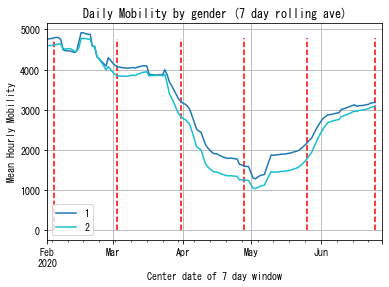

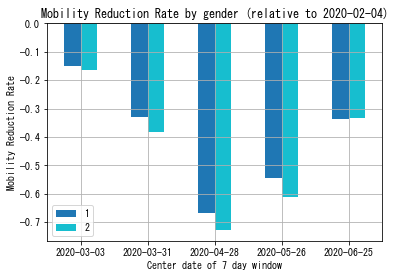

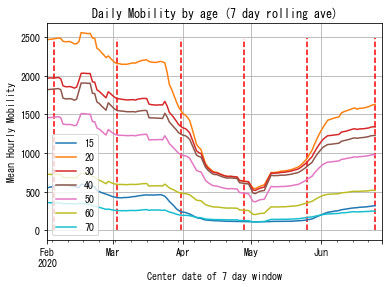

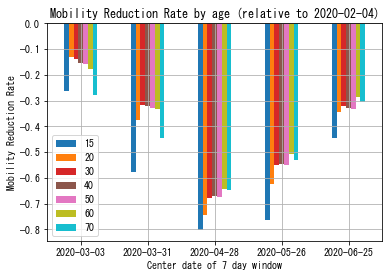

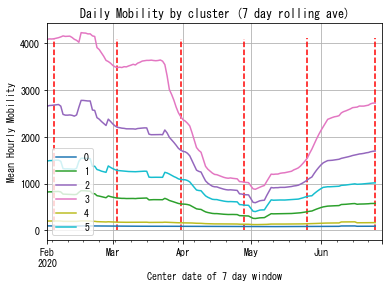

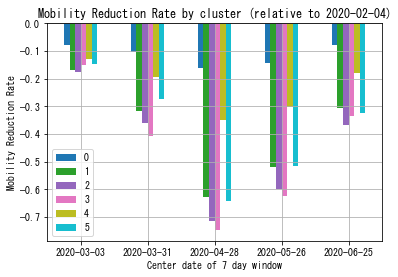

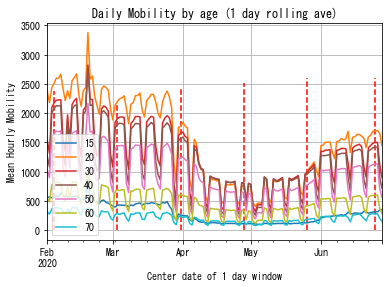

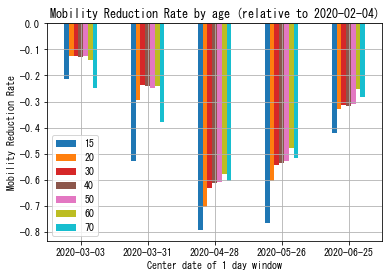

time: 3 s


In [6]:
# Plot mobility by age group and sex and publishrrrr
debug = True
debug = False

df = read_cache("00001_c")
df = df[list(map(lambda x: x[2] != 0, df.index))]   # Remove gender==0 records
df = df.iloc[:, 1:]   # Remove Jan. 1 because it has no mobility data
# display(df[list(map(lambda x: x[0] == 3, df.index))])
# plt.rcParams['figure.figsize'] = (20, 10)
plot_mobility_by_cat(df,["gender"], reference_dates, publish=True)
plot_mobility_by_cat(df,["age"], reference_dates, publish=True)
plot_mobility_by_cat(df,["cluster"], reference_dates, publish=True)

plot_mobility_by_cat(df,["age"], reference_dates, window=1)
#plot_mobility_by_cat(df,["gender"], reference_dates, cluster=3)
#plot_mobility_by_cat(df,["age"], reference_dates, cluster=3)

#plot_mobility_by_cat(df,["gender"], reference_dates, cluster=2)
#plot_mobility_by_cat(df,["age"], reference_dates, cluster=2)


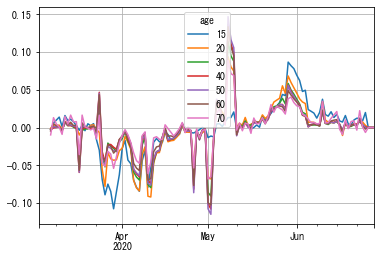

time: 312 ms


In [7]:
df1 = df.groupby("age").sum().resample("1D", axis=1).mean().loc[:, "2020-03-03":]
# df1.loc[pd.to_datetime("2020-03-15"):].plot()
df1 = df1.rolling(7, center=True, axis=1).mean()
df1.T.pct_change().plot(grid=True)

f:/Users/Hiroshi/Desktop/DoCoMo/cache/pref_name.pickle loaded.


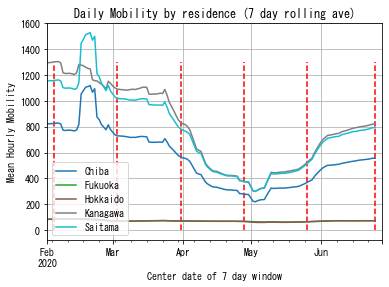

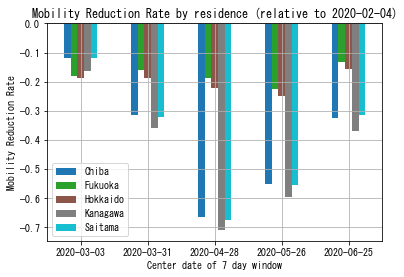

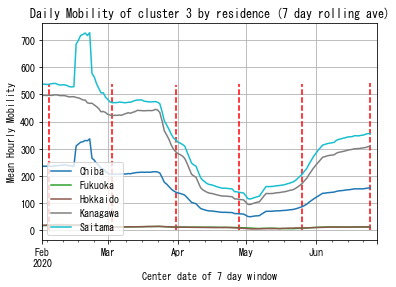

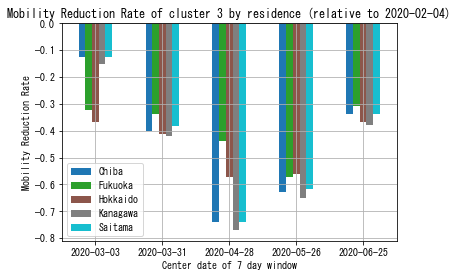

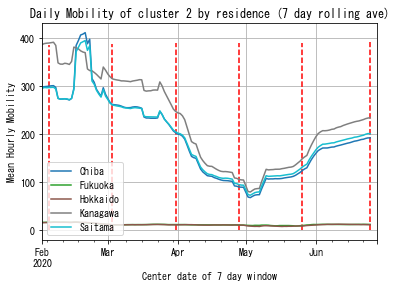

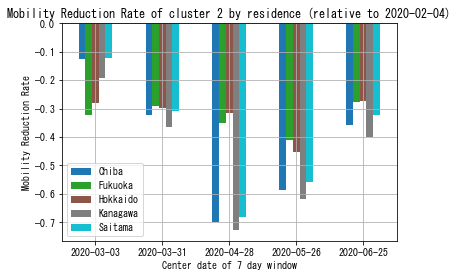

time: 1.67 s


In [8]:
# Try 00002_c, the residence prefecture
# print(pref_name_def)
fn = cache_dir + "pref_name.pickle"
if os.path.exists(fn):
    with open(fn, 'rb') as f:
        pref_name_def = pickle.load(f)
        print("{} loaded.".format(fn))

code_list = dict(zip([int(x) for x in pref_name_def],
             [pref_name_def[x]['name_en'] for x in pref_name_def],
             ))
# print(code_list)
pref_list = ["神奈川県", "埼玉県", "千葉県", "北海道", "福岡県"]
pref_list = ["Kanagawa", "Saitama", "Chiba", "Hokkaido", "Fukuoka"]

# print(pref_list_in_code)
debug = False
df = read_cache("00002_c")
df = df[list(map(lambda x: x[1] != 0, df.index))]    # Remove residence==0 records
df.reset_index(inplace=True)
df['residence'] = df['residence'].apply(lambda x: code_list[x])
df.set_index(['cluster', 'residence'], inplace=True)
df.columns = pd.to_datetime(df.columns)
# display(df.columns)
# df = df[list(map(lambda x: x[1] != 13, df.index))]   # Remove Tokyo records
df = df[list(map(lambda x: x[1] in pref_list, df.index))] 
df = df.iloc[:, 1:]   # Remove Jan. 1 because it has no mobility data
plot_mobility_by_cat(df,["residence"], reference_dates, publish=True)
plot_mobility_by_cat(df,["residence"], reference_dates, cluster=3)
plot_mobility_by_cat(df,["residence"], reference_dates, cluster=2)
#plot_mobility_by_cat(df,["residence"], reference_dates, cluster=5)
# df

In [9]:
# Load the row-based data and convert them into a time_pop_table
# Only new data up until yesterday will be processed and appended to the table file
# How to download files from S3
# $ aws s3 sync s3://mobaku-delivery-user002 .
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
%load_ext autotime

def read_time_pop_table(year):
    t = pd.read_csv(cache_dir + year + "_out2.csv", parse_dates=[0]) \
        .rename(columns={"Unnamed: 0": "Date_Time"}) \
        .set_index("Date_Time")
    return t

year = "2020"
time_pop_table_t = read_time_pop_table(year).T
# display(time_pop_table_t.head())
# print(time_pop_table_t.index)

last_date = time_pop_table_t.columns[-1]
print("last_date = ", last_date)
print(pd.Timestamp.today())
dates_to_add = pd.date_range(start=last_date.date()+pd.Timedelta('1 days'), end=pd.Timestamp.today()-pd.Timedelta('1 days'))
print(dates_to_add)

for d in dates_to_add:
    d_str = d.strftime("%Y%m%d")
    for h in range(24):
        f = data_dir + "s3/realtime/{}/clipped_mesh_pop_{}{:02d}00_00000.csv.zip".format(d_str,d_str,h)
        print("Reading {}...".format(f))
        hourly = pd.read_csv(f,usecols=["area", "population"], dtype={"area": str})
        hourly = hourly.set_index("area")
        d_h = d + pd.Timedelta('{} hours'.format(h))
        hourly.rename(columns={"population": d_h}, inplace=True)
        # print(d_h)
        # display(hourly.head())
        # print(hourly.index)
        time_pop_table_t = time_pop_table_t.merge(hourly, how='left', left_index=True, right_index=True)
    
time_pop_table_t.T.to_csv(cache_dir + year + "_out2.csv")


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
last_date =  2020-06-28 23:00:00
2020-06-29 09:40:11.111572
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
time: 54.1 s


In [10]:
# Load the row-based data and convert them into a table

import pandas as pd
import matplotlib.pyplot as plt
import os


year = "2020"
year = "2019"

def convert_to_table(year):
    fn = "data/DoCoMo/" + year + "_all.csv"
    if os.path.exists(fn):
        pass
    else:
        d = pd.read_csv(fn,usecols=[0,1,2,6],names=["Date", "Time", "Mesh", "Population"],
                        # dtype={"Mesh":str},
                        parse_dates=[[0,1]],header=None)

        print("{} loaded, n_records={}".format(fn, len(d)))
        start_time, end_time = d["Date_Time"].min(), d["Date_Time"].max()
        time_range = pd.date_range(start=start_time, end=end_time, freq='H')
        print("time_range=", time_range)
        mesh_list = d["Mesh"].unique()
        print("n_mesh=", len(mesh_list))
        print("mesh_list=", mesh_list)
        df = pd.DataFrame(index=time_range, columns=mesh_list)

        for i, row in d.iterrows():
            if i % 100000 == 0:
                print("{}: Processing record {}...".format(pd.Timestamp.now(), i))
            date_time = row[0]
            mesh = row[1]
            population = row[2]
            df.loc[date_time, mesh] = population

        df.to_csv("Data/DoCoMo/" + year + "_out2.csv")

# convert_to_table("2019")
# convert_to_table("2020")

time: 7.99 ms


In [11]:
# Load table data into DataFrame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autotime
default_figsize = plt.rcParams['figure.figsize']

def read_out2(year):
    df = pd.read_csv(cache_dir + year + "_out2.csv", parse_dates=[0])
    df = df.rename(columns={'Unnamed: 0':"Date_Time"}).set_index("Date_Time").fillna(0)
    l1_delta = np.zeros(len(df))
    l2_delta = np.zeros(len(df))
    mean = np.zeros(len(df))
    std = np.zeros(len(df))
    for i in range(1,len(df)):
        l1_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=1)
        l2_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=2)
        mean[i] = df.iloc[i].mean()
        std[i] = df.iloc[i].std()
    df["L1"] = l1_delta
    df["L2"] = l2_delta
    df["mean"] = mean
    df["std"] = std
    return df


pop_2019 = read_out2("2019")
pop_2020 = read_out2("2020")



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1min 37s


Date_Time,2020-01-01 00:00:00,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,...,2020-06-28 14:00:00,2020-06-28 15:00:00,2020-06-28 16:00:00,2020-06-28 17:00:00,2020-06-28 18:00:00,2020-06-28 19:00:00,2020-06-28 20:00:00,2020-06-28 21:00:00,2020-06-28 22:00:00,2020-06-28 23:00:00
374112352,NaN,0.0,3.0,4.0,3.0,2.0,9.0,0.0,3.0,2.0,...,8.0,3.0,15.0,2.0,36.0,16.0,16.0,17.0,31.0,14.0
374112361,NaN,2.0,6.0,8.0,15.0,4.0,12.0,4.0,14.0,17.0,...,6.0,1.0,11.0,29.0,20.0,32.0,7.0,6.0,17.0,12.0
394271832,NaN,10.0,5.0,4.0,19.0,23.0,3.0,2.0,4.0,20.0,...,34.0,26.0,22.0,26.0,18.0,10.0,13.0,5.0,3.0,14.0
394271834,NaN,6.0,5.0,4.0,2.0,1.0,18.0,18.0,7.0,11.0,...,4.0,7.0,2.0,1.0,18.0,4.0,21.0,7.0,6.0,16.0
394271922,NaN,26.0,1.0,23.0,4.0,1.0,16.0,4.0,2.0,16.0,...,23.0,27.0,19.0,23.0,0.0,2.0,11.0,29.0,16.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404201324,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404201521,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404201412,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533950141,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


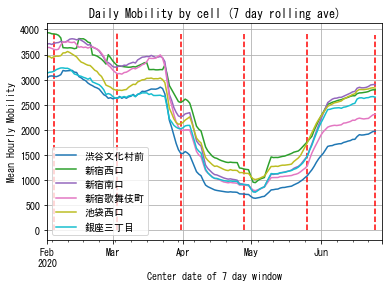

ValueError: Format '\n404241691  0\n404241343  0\n404241584  0\n404241442  0\n404241441  0\n\n[8532 rows x 1 columns])' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

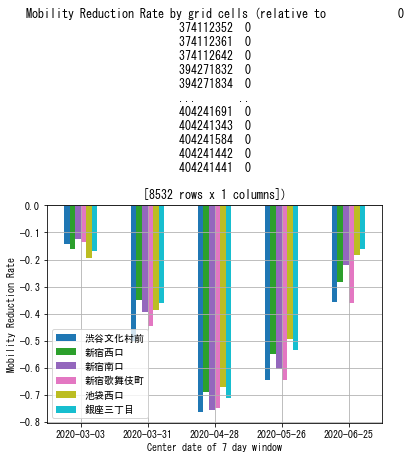

time: 1.91 s


In [12]:
cluster3_cells = {'533935952':"渋谷文化村前",
             '533945254':"新宿西口",
             '533945263':"新宿南口",
             '533945361':"新宿歌舞伎町",
             '533945764':"池袋西口",
             '533946013':"銀座三丁目"
            }

df_bycell = pop_2020.drop(columns=['L1', 'L2', 'mean', 'std']).T.diff(axis=1).abs()
display(df_bycell)
plot_mobility_by_grid(df_bycell, cluster3_cells, reference_dates, publish=True)

In [ ]:
def holiday_p(d):
    national_holidays = pd.to_datetime(["2019-1-1", "2019-1-2", "2019-1-3", "2019-1-14", "2019-2-11", "2019-3-21",
                                        "2020-1-1", "2020-1-2", "2020-1-3", "2020-1-13", "2020-2-11", "2020-2-24", 
                                        "2020-3-20","2020-4-29","2020-5-4", "2020-5-5",  "2020-5-6"
                                       ])
    if d.dayofweek in [5,6]:
        return True
    if d in national_holidays:
        return True
    else:
        return False

def adjust_to_weekdays(week):
    a = week[week["Holiday"]==False].mean()["L1"]
    # print(a)
    return a

s = pd.date_range('2019-1-1', '2019-3-31', freq='D')

holiday_2019 = pd.DataFrame(s, columns=["Date"])
# display(holiday_2019)
holiday_2019["Holiday"] = holiday_2019["Date"].apply(lambda x: holiday_p(x))

display(holiday_2019)
m = pop_2019["L1"].resample("1D").mean()
m = holiday_2019.merge(m, right_index=True, left_on="Date", how="outer")
display(m)
adjusted = np.zeros(len(m))
# print(adjusted)
for i in range(3, len(m)-2):
    # print(i)
    if m["Holiday"].iloc[i]:
        adjusted[i] = adjust_to_weekdays(m.iloc[i-3:i+3])
    else:
        adjusted[i] = m.iloc[i]["L1"]

m["Adjusted"] = adjusted
m = m[7:-3].set_index("Date")  # 3が日にデータは使えない
m.plot()
plt.show()

m1 = m[m["Holiday"]]
for d in range(7):
    m2 = m1[m1.index.dayofweek == d]
    display(m2)
    if len(m2)> 0:
        plt.scatter(m2["L1"], m2["Adjusted"], label=m2.index[0].day_name())

plt.xlabel("L1")
plt.ylabel("Adjusted")
plt.legend()
plt.show()

plt.hist(m1["L1"] / m1["Adjusted"], bins=10)
# m.apply(lambda x: print(x))

In [ ]:
# plot various mobility indicators 

def mobility_plot(df, metric, year, w):
    mobility = df[metric]
    daily_mobility = mobility.resample('1D').mean().rolling(w, center=True).mean()
    plt.title("Daily Mobility Index ({}), year={}, rolling window={}".format(metric, year,w))
    daily_mobility.plot(grid=True)
    plt.show()


# mobility_plot(pop_2020.loc[pd.to_datetime("2020-02-01"):], "L1", "2020", 7)
    
mobility_plot(pop_2019, "L1", "2019", 1)
mobility_plot(pop_2019, "L1", "2019", 7)
mobility_plot(pop_2020, "L1", "2020", 1)
mobility_plot(pop_2020, "L1", "2020", 7)

#mobility_plot(pop_2019, "L2", "2019", 1)
#mobility_plot(pop_2019, "L2", "2019", 7)
mobility_plot(pop_2020, "L2", "2020", 1)
mobility_plot(pop_2020, "L2", "2020", 7)

#mobility_plot(pop_2019, "mean", "2019", 1)
#mobility_plot(pop_2019, "mean", "2019", 7)
mobility_plot(pop_2020, "mean", "2020", 1)
mobility_plot(pop_2020, "mean", "2020", 7)

#mobility_plot(pop_2019, "std", "2019", 1)
#mobility_plot(pop_2019, "std", "2019", 7)
mobility_plot(pop_2020, "std", "2020", 1)
mobility_plot(pop_2020, "std", "2020", 7)



## Confirmed Cases in Tokyo
- Data source: [Tokyo Metropolitan Governmnet Open Data Catalogue Site](https://portal.data.metro.tokyo.lg.jp/) [Dashboard](https://stopcovid19.metro.tokyo.lg.jp/)

In [ ]:
# Load confirmed cases

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)

daily_confirmed_cases = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv',
                    usecols=["公表_年月日", "患者_年代", "患者_性別"],
                    parse_dates=["公表_年月日"]) \
    .groupby("公表_年月日") \
    .count().drop(columns=["患者_年代"]) \
    .reset_index() \
    .rename(columns={"患者_性別": "Confirmed_Cases", "公表_年月日": "Date_Time"}) \
    .set_index("Date_Time")

daily_confirmed_cases = daily_confirmed_cases.asfreq('1D', fill_value=0)

# display(daily_confirmed_cases.asfreq('1D', fill_value=0))

window = 7
# plt.grid()
daily_confirmed_cases["Cumulative"] = daily_confirmed_cases["Confirmed_Cases"].cumsum()
daily_confirmed_cases["GrowthRate"] = daily_confirmed_cases["Cumulative"].pct_change().rolling(window, center=True).mean()
daily_confirmed_cases = daily_confirmed_cases["2020-03-01":]
days = len(daily_confirmed_cases)
print("Days in daily_confirmed_cases=", len(daily_confirmed_cases))

plt.title("Daily Growth Rate of Confirmed Cases ({} days rolling average)".format(window)) 
(daily_confirmed_cases["GrowthRate"] + 1.0).plot()
daily_confirmed_cases

In [ ]:
# Caculate correlations between mobility and growth rate of confirmed cases

import datetime 

daily_pop = pop_2020.resample('1D').mean().rolling(7, center=True).mean()
# display(daily_confirmed_cases)

last_date_pop = daily_pop.index[-1]
last_date_confirmed = daily_confirmed_cases.index[-1]
first_date_confirmed = daily_confirmed_cases.index[0]
min_delay = last_date_confirmed - last_date_pop
days_in_confirmed_cases = last_date_confirmed - first_date_confirmed
print("last date in mobility =",last_date_pop)
print("last date confirmed =", last_date_confirmed )
print("first date confirmed =", first_date_confirmed )
print("min_delay = ", min_delay.days)
print("days in confirmed_cases =", days_in_confirmed_cases)

w = 20 # max delta t
corr = np.zeros(w)
for delta_t in range(min_delay.days, w):
    s0 = first_date_confirmed - datetime.timedelta(days=delta_t)
    e0 = s0 + days_in_confirmed_cases
    m = daily_pop["L1"][s0:e0]
    s1 = s0 + datetime.timedelta(days=delta_t)
    e1 = e0 + datetime.timedelta(days=delta_t)
    g = daily_confirmed_cases["GrowthRate"][s1:e1]
    print(delta_t, s0, e0, s1, e1, m.shape, g.shape)
    corr[delta_t] = m.corr(g)
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.suptitle("Mobility vs Growth Rate (delta_t={})".format(delta_t))
    m.plot(ax=axs[0, 0])
    g.plot(ax=axs[0, 1])
    axs[1, 0].scatter(m, g)
    plt.show()
    # print(d, len(n_calls), len(n_reported), corr[d])

plt.grid()
plt.title("Corr. btw mobility and growth rate")
plt.xlabel("Delay in days")
plt.ylabel("Corr")
plt.plot(np.array(range(min_delay.days, w)), corr[min_delay.days:w])

### Granger Causality Tests between mobility and reported cases

In [ ]:
# lag = 4日～12日において、帰無仮説が棄却されている

from statsmodels.tsa.stattools import grangercausalitytests
from sklearn import preprocessing

def prep_timeseries(ts):
    # display(ts)
    # ts = (ts + 1).pct_change()
    ts = ts.diff()
    ts = ts.diff()
    return preprocessing.scale(ts[2:])

def plot_granger_causality(df, lag_max=50, verbose=False, title="Granger Causality Test Results (ssr_ftest)"):
    if verbose:
        display(df)
    df.plot()
    # plt.title("Timeseries 0 is copying timeseries 1 with lag = {}".format(lag))
    plt.show()
    df.hist()
    # plt.title("Distribution of each timeseries")
    plt.show()
    gc_res = grangercausalitytests(df, lag_max, verbose=verbose)

    p_values = np.array([v[0]['ssr_ftest'][1] for v in gc_res.values()])
    plt.plot(np.arange(1, lag_max + 1), p_values)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.hlines(0.05, 1, lag_max, "red", linestyles='dashed')
    plt.show()
    

x1 = daily_confirmed_cases["Confirmed_Cases"]
print(len(daily_confirmed_cases["Confirmed_Cases"]))

t = read_cache("00000_c")
x2 = t.iloc[4]["2020-03-01":].resample('1D').mean()
x1 = prep_timeseries(x1)
x2 = prep_timeseries(x2)
df = pd.DataFrame([x1, x2]).T
# df.plot()
plot_granger_causality(df, lag_max=16)

# Statistics on Mobility Data


In [ ]:
mean = pop_2019.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = pop_2019.drop(columns=["L1", "L2", "mean", "std"]).std()



plt.title("Mean population vs std")
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std)
large_mean = mean[mean>12000]
for mesh in large_mean.index:
    plt.text(mean[mesh]+500, std[mesh]-300, str(mesh)[-4:], fontsize=7 )

plt.show()

plt.title("Distribution of mean population (2019)")
plt.xlabel("Mean population")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(mean, bins=300)
# plt.plot(mean.cumsum())
plt.show()

plt.title("Distribution of standard diviation (2019)")
plt.xlabel("Standard diviation")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(std, bins=100)
plt.show()

print("Large mean grids")
print(mean[mean>10000].sort_values(ascending=False))
print("Large std grids")
print(std[std>15000].sort_values(ascending=False))

# large_mean.index

- 平均人口が最も多いのは歌舞伎町 The largest mean populatioin is at Kabuki-cho (533945361    27699.655220)
- 標準偏差が最も大きいのは大手町 The largest standard diviation is at Otemachi（533946211    20066.947698）

You can check the location of a meshcode at [Geocode Viewer](http://www.geosense.co.jp/map/tool/geoconverter.php) 

まあ、そうだろう、という感じ The results are no surprise.

In [ ]:
# Plot daily mean population for selected grid cells

focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
to_plot = pop_2019[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .resample('1D').mean()

to_plot .plot()
plt.title("Daily Mean Population in 2019")
to_plot.std()
for key in focused_grids:
    print(key,focused_grids[key], mean[key], std[key] )


In [ ]:
# Other statistics for selected grid cells

from sklearn import preprocessing

focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
# focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
# 歌舞伎町と大手町の人口ヒストグラム
pop_2019[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .hist(bins=12)
plt.show()

hour_of_day = pop_2020.groupby(pop_2020.index.hour).mean()
hour_of_day = hour_of_day[list(focused_grids.keys())] \
    .rename(columns=focused_grids)


h = preprocessing.scale(hour_of_day)
for i in range(len(hour_of_day.columns)):
    plt.plot(range(24),h[:, i],label=hour_of_day.columns[i])
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 24, step=3))
plt.title("Hourly Diviation from Mean (2019)")
plt.xlabel("Hour of Day")
plt.ylabel("Diviation from Mean")
plt.show()
hour_of_day.columns

## Correlation with onset dates

- Data source:  [Jag Japan](https://gis.jag-japan.com/covid19jp/)

Unfortunately the data has no onset date for recent Tokyo cases.

In [ ]:
# Correlation with onset dates

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)
fn = 'https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'
# fn = 'data/JAG_Japan/COVID-19.csv'

def read_data():
    d = pd.read_csv(fn,usecols=["確定日", "発症日", "受診都道府県"],parse_dates=["確定日", "発症日"])
    d = d.drop(["不明", "中部国際空港", "成田空港", "羽田空港", "関西国際空港"], errors='ignore')
    return d


jag_report = read_data()
last_date = jag_report["確定日"].max()
print("last_date=", last_date, "n_records=", len(jag_report))
jag_report = jag_report.drop(columns=["確定日"])
print(len(jag_report[jag_report["受診都道府県"]=="東京都"]))
onset = jag_report[jag_report["受診都道府県"]=="東京都"].groupby("発症日").count()
onset.plot()
onset.sum()

発症日のデータを取ってみたが、東京都の症例では、最近は発症日が記入されていない。このため、よい相関が取れない。あきらめ。


In [ ]:
# Experimantal code. Please ignore
if 0: 

    fig, ax1 = plt.subplots()

    # ヒストグラムプロットとビン情報の取得
    n, bins, patches = ax1.hist(mean, alpha=0.7, label='Frequency', bins=20)
    ax1.grid(axis='x')
    ax1.set_xlabel("Grid Population")
    ax1.set_ylabel("Frequency")

    # 第2軸用値の算出
    y2 = np.add.accumulate(n) / n.sum()
    x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

    # 第2軸のプロット
    ax2 = ax1.twinx()
    lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
             label='Cumulative ratio')
    ax2.grid(visible=True)
    ax2.set_ylabel("Cumulative %")

    plt.show()

In [ ]:
# Experimantal code. Please ignore

if 0: 
    ranked_means = mean.sort_values(ascending=False)
    # print(ranked_means)
    total = ranked_means.sum()
    print("sum=", total)
    top_n = 100

    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(top_n), ranked_means[:top_n])
    ax2 = ax1.twinx()
    ax2.plot(ranked_means[:top_n].cumsum() / total)
    plt.show()

In [ ]:
# Experimantal code. Please ignore

if 0: 
    # 平成25年住宅・土地統計調査 確報集計
    print(pd.__version__)
    fn = 'data/estat/FEH_00200522_200408215652.csv'

    def read_data():
        d = pd.read_csv(fn, skiprows=14, sep=',', usecols=["H25地域", "世帯の年間収入階級_2013", "総数" ], 
                        thousands=',', encoding="SHIFT-JIS")
        d["総数"] = d["総数"].str.replace(',', '')
        d["総数"] = d["総数"].str.replace('-', '0')  #  '-' はゼロと解釈
        d["総数"] = d["総数"].astype(int)
        return d

    rank = [0, 100, 200, 300, 400, 500, 700, 1000, 1500]
    # rank = [50, 150, 250, 350, 450, 600, 850, 1250, 1500]

    def median(total, counts):
        # print("total=", total, "counts=", counts)
        h = total / 2
        c = 0
        for i in range(len(counts)):
            c += counts.values[i]
            if c > h:
                return rank[i]
        return None

    household_income = read_data()
    # print(household_income["総数"])
    n_records = len(household_income)
    meds = np.zeros(n_records)
    for i in range(0, n_records, 10):
    # for i in range(0, 1, 10):
        # print(household_income.iloc[i]["H25地域"])
        m = median(household_income.iloc[i]["総数"], household_income.iloc[i+1:i+10]["総数"])
        meds[i] = m

    household_income["Median"] = meds

    household_income


## Research Question: Which areas show larger mobility changes due to COVID-19?

1. Cluster grid cells on 2019 data
- Define mobility reduction
    - Take two time points, $t_1$ and $t_2$, and compute the mobility difference $\Delta = d(m(t_1), m(t_2))$
    - Let's take three Tuesdays, $t_0=$ Feb 4 (before Diamond Princess), $t_1$ = Mar 3 (after school closure), and $t_2=$ Mar 31 (lockdown imminent).
    - Calculate $\Delta = d(m(t_0), m(t_1))$ and $\Delta = d(m(t_0), m(t_2))$ for every cell

In [ ]:
# Cluster grid cells

from sklearn.cluster import KMeans
from matplotlib import colors as mcolors
import pickle
import os

mobility_2019_L1 = pop_2019.drop(columns=["L1", "L2", "mean", "std"]).diff().abs()
#mobility_2019_L1 = pop_2019.drop(columns=["L1", "L2", "mean", "std"])
mobility_2019_L1_daily = mobility_2019_L1.groupby(mobility_2019_L1.index.hour).mean()

# display(mobility_2019_L1_daily.columns)
# If already clustered, use them

cluster_fn = cache_dir + 'cluster.pickle'
n_clusters = 6
if os.path.exists(cluster_fn):
    with open(cluster_fn, 'rb') as f:
        pred = pickle.load(f)
    print('Using saved cluster', cluster_fn)
else:
    pred = KMeans(n_clusters=n_clusters).fit_predict(mobility_2019_L1_daily.values.T)
    pred = pd.DataFrame(pred.astype(int), index=mobility_2019_L1_daily.columns)
    print(pred)
    with open(cluster_fn, 'wb') as f:
        pickle.dump(pred, f)

mean = pop_2019.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = pop_2019.drop(columns=["L1", "L2", "mean", "std"]).std()

cmap = plt.get_cmap("tab10")

# Scatter Plot between mean and std
plt.title("Clustered grid cells (k={}) on mean population vs std".format(n_clusters))
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std, c=pred, cmap=cmap)
mobility_2019_L1_daily_t = mobility_2019_L1_daily.T
mobility_2019_L1_daily_t["cluster"] = pred

# Hourly population by Cluster
title = "Hourly Mobility by Cluster (2019)"
mobility_2019_L1_daily_t.groupby("cluster").mean().T.plot(title=title, cmap=cmap, grid=True)
plt.xlabel("Hour of Day")
plt.show()

# Population hourly diviation from mean by Cluster
h = pop_2019.drop(columns=["L1", "L2", "mean", "std"]).T

h = h.merge(cluster, how='inner', left_index=True, right_index=True).groupby(0).mean().T
#display(h)
h = h.groupby(pop_2019.index.hour).mean()
#display(h)
h = preprocessing.scale(h)
print(h.shape)
for i in range(h.shape[1]):
    plt.plot(range(24),h[:, i],label="Cluster {}".format(i))
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 24, step=3))
plt.title("Population hourly diviation from mean by Cluster (2019)")
plt.xlabel("Hour of Day")
plt.ylabel("Diviation from Mean")
plt.show()



clustered_cells = mobility_2019_L1_daily_t["cluster"]
clustered_cells_df = pd.DataFrame(clustered_cells).reset_index().rename(columns={"index": "meshcode"})


## Plot results on map
- This code is by Kunihiko Miyoshi (https://github.com/colspan)

- Data source: 
    - 国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
    - 国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html
    - GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson

In [ ]:
# This code is by Kunihiko Miyoshi (https://github.com/colspan)
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime

%matplotlib inline
%load_ext autotime

fn = cache_dir + "pref_name.pickle"
if os.path.exists(fn):
    with open(fn, 'rb') as f:
        pref_name_def = pickle.load(f)
        print("{} loaded.".format(fn))
else:
    pref_name_def = {
        "01": {
            "name_jp": "北海道",
            "name_en": "Hokkaido"
        },
        "02": {
            "name_jp": "青森県",
            "name_en": "Aomori"
        },
        "03": {
            "name_jp": "岩手県",
            "name_en": "Iwate"
        },
        "04": {
            "name_jp": "宮城県",
            "name_en": "Miyagi"
        },
        "05": {
            "name_jp": "秋田県",
            "name_en": "Akita"
        },
        "06": {
            "name_jp": "山形県",
            "name_en": "Yamagata"
        },
        "07": {
            "name_jp": "福島県",
            "name_en": "Fukushima"
        },
        "08": {
            "name_jp": "茨城県",
            "name_en": "Ibaraki"
        },
        "09": {
            "name_jp": "栃木県",
            "name_en": "Tochigi"
        },
        "10": {
            "name_jp": "群馬県",
            "name_en": "Gunma"
        },
        "11": {
            "name_jp": "埼玉県",
            "name_en": "Saitama"
        },
        "12": {
            "name_jp": "千葉県",
            "name_en": "Chiba"
        },
        "13": {
            "name_jp": "東京都",
            "name_en": "Tokyo"
        },
        "14": {
            "name_jp": "神奈川県",
            "name_en": "Kanagawa"
        },
        "15": {
            "name_jp": "新潟県",
            "name_en": "Niigata"
        },
        "16": {
            "name_jp": "富山県",
            "name_en": "Toyama"
        },
        "17": {
            "name_jp": "石川県",
            "name_en": "Ishikawa"
        },
        "18": {
            "name_jp": "福井県",
            "name_en": "Fukui"
        },
        "19": {
            "name_jp": "山梨県",
            "name_en": "Yamanashi"
        },
        "20": {
            "name_jp": "長野県",
            "name_en": "Nagano"
        },
        "21": {
            "name_jp": "岐阜県",
            "name_en": "Gifu"
        },
        "22": {
            "name_jp": "静岡県",
            "name_en": "Shizuoka"
        },
        "23": {
            "name_jp": "愛知県",
            "name_en": "Aichi"
        },
        "24": {
            "name_jp": "三重県",
            "name_en": "Mie"
        },
        "25": {
            "name_jp": "滋賀県",
            "name_en": "Shiga"
        },
        "26": {
            "name_jp": "京都府",
            "name_en": "Kyoto"
        },
        "27": {
            "name_jp": "大阪府",
            "name_en": "Osaka"
        },
        "28": {
            "name_jp": "兵庫県",
            "name_en": "Hyogo"
        },
        "29": {
            "name_jp": "奈良県",
            "name_en": "Nara"
        },
        "30": {
            "name_jp": "和歌山県",
            "name_en": "Wakayama"
        },
        "31": {
            "name_jp": "鳥取県",
            "name_en": "Tottori"
        },
        "32": {
            "name_jp": "島根県",
            "name_en": "Shimane"
        },
        "33": {
            "name_jp": "岡山県",
            "name_en": "Okayama"
        },
        "34": {
            "name_jp": "広島県",
            "name_en": "Hiroshima"
        },
        "35": {
            "name_jp": "山口県",
            "name_en": "Yamaguchi"
        },
        "36": {
            "name_jp": "徳島県",
            "name_en": "Tokushima"
        },
        "37": {
            "name_jp": "香川県",
            "name_en": "Kagawa"
        },
        "38": {
            "name_jp": "愛媛県",
            "name_en": "Ehime"
        },
        "39": {
            "name_jp": "高知県",
            "name_en": "Kochi"
        },
        "40": {
            "name_jp": "福岡県",
            "name_en": "Fukuoka"
        },
        "41": {
            "name_jp": "佐賀県",
            "name_en": "Saga"
        },
        "42": {
            "name_jp": "長崎県",
            "name_en": "Nagasaki"
        },
        "43": {
            "name_jp": "熊本県",
            "name_en": "Kumamoto"
        },
        "44": {
            "name_jp": "大分県",
            "name_en": "Oita"
        },
        "45": {
            "name_jp": "宮崎県",
            "name_en": "Miyazaki"
        },
        "46": {
            "name_jp": "鹿児島県",
            "name_en": "Kagoshima"
        },
        "47": {
            "name_jp": "沖縄県",
            "name_en": "Okinawa"
        },
    }
    with open(fn, 'wb') as f:
        pickle.dump(pref_name_def, f)
        print("{} saved.".format(fn))

# define functions

def meshcode_to_latlng(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = float((int(meshcode[8])-1) // 2) * 1.0/8.0/10.0/2.0/1.5
        half_lon = float((int(meshcode[8])-1) % 2) * 1.0/8.0/10.0/2.0
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = float(meshcode[0:2])/1.5 + float(meshcode[4]) * \
        1.0/8.0/1.5 + float(meshcode[6])*1.0/8.0/10.0/1.5 + half_lat
    longtitude = float(meshcode[2:4])+100.0 + float(meshcode[5]) * \
        1.0/8.0 + float(meshcode[7])*1.0/8.0/10.0 + half_lon
    return (latitude, longtitude)


def meshcode_to_latlng_index(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = (int(meshcode[8])-1) // 2
        half_lon = (int(meshcode[8])-1) % 2
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = int(meshcode[0:2])*8*10*2 + int(meshcode[4]
                                               )*10*2 + int(meshcode[6])*2 + half_lat
    longtitude = int(meshcode[2:4])*8*10*2 + \
        int(meshcode[5])*10*2 + int(meshcode[7])*2 + half_lon
    return (latitude, longtitude)

def llindex_to_latlng(lli):
    return (
        float(lli[0]) / 2 / 8 / 10 / 1.5,
        float(lli[1]) / 2 / 8 / 10 + 100)

def meshcode_to_polygon(meshcode):
    south_west_i = meshcode_to_latlng_index(meshcode)

    lat_i, lon_i = south_west_i
    diff = 1 if len(meshcode) == 9 else 2
    north_east_i = (lat_i + diff, lon_i + diff)
    sw_geo = llindex_to_latlng(south_west_i)
    ne_geo = llindex_to_latlng(north_east_i)

    coordinates = [
        [sw_geo[1], sw_geo[0]],
        [sw_geo[1], ne_geo[0]],
        [ne_geo[1], ne_geo[0]],
        [ne_geo[1], sw_geo[0]],
        [ne_geo[1], sw_geo[0]]
    ]
    return coordinates

df_tokyo = gpd.read_file('data/JapanCityGeoJason/13_tokyo.json')
# 重複を除外する
df_tokyo = df_tokyo[df_tokyo['id']!='13']
# 諸島を除外する
df_tokyo = df_tokyo[df_tokyo['id'].apply(lambda x: int(x)<13361)]

# 注意 : このデータを利用するには下記クレジットが必要
'''
国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html

GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson
'''
# 地図を描画
ax = df_tokyo.boundary.plot(color='blue')



In [ ]:
from shapely.geometry import Polygon
# figsize_save = plt.rcParams['figure.figsize']
def show_cells_on_map(df, column, cmap=cmap, title=None, legend=False, legend_kwds=None):
    # df should have "meshcode" for meshcode and column for the data to be displayed
    plt.rcParams['figure.figsize'] = (20, 10)
    # 島しょ部を除外する
    df_poplog_geo = df[df.meshcode > '530000000']
    df_poplog_geo = gpd.GeoDataFrame(df_poplog_geo)

    # meshcodeに対応するポリゴンを生成する
    df_poplog_geo['geometry'] = df_poplog_geo['meshcode'].apply(lambda x: Polygon(meshcode_to_polygon(x)))  

    ax = df_poplog_geo.plot(column=column, cmap=cmap, legend=legend, legend_kwds=legend_kwds)
    plt.title(title)
    plt.rcParams['figure.figsize'] = default_figsize
    
show_cells_on_map(clustered_cells_df, 'cluster', title="Cluster")

In [ ]:
# Mobility Time Series by Cluster
window = 1
reference_dates = pd.to_datetime(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-28'])
mobility_2020_L1 = pop_2020.drop(columns=["L1", "L2", "mean", "std"]).diff().abs()

mobility_by_cells = mobility_2020_L1.resample('1D').mean().rolling(window, center=True).mean().loc['2020-2-1':].T
m = mobility_by_cells.copy()
m["cluster"] = cluster
title = "Daily Mobility by Cluster ({} day rolling ave)".format(window)
mobility_by_cluster = m.groupby("cluster").mean().T
# print(mobility_by_cluster.shift(- (window // 2)))
# mobility_by_cluster.shift(- (window // 2)).plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
mobility_by_cluster.plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.ylabel("Mean Hourly Mobility")
plt.vlines(reference_dates, 0, 3500, "red", linestyles='dashed')

# mobility reduction rate by cluster
m = mobility_by_cluster.T.loc[:,reference_dates]
for t in range(1, len(reference_dates)):
    m[reference_dates[t]] =  m[reference_dates[t]] / m[reference_dates[0]] - 1.0

display(m.drop(columns=reference_dates[0]).T)
m.drop(columns=reference_dates[0]).T.plot.bar(cmap=cmap, grid=True)
plt.title("Mobility Reduction Rate (relative to {})".format(reference_dates[0].date()))
plt.ylabel("Mobility Reduction Rate")
plt.xticks(range(len(reference_dates[1:])), reference_dates[1:].date, rotation=0)
plt.show()

# mobility reduction by cells
m = mobility_by_cells
reduction_by_cells = m[reference_dates[0]] - m[reference_dates[-1]] 
log_reduction_by_cells = np.log(reduction_by_cells - reduction_by_cells.min() + 1)
reduction_by_cells = reduction_by_cells.rename("reduction")
# reduction_by_cells["log_reduction"] = log_reduction_by_cells
print(reduction_by_cells.describe())
# reduction_by_cells.T.loc["533945361"]  # 歌舞伎町
reduction_by_cells = reduction_by_cells.reset_index().rename(columns={"index":"meshcode", 0:"t1", 1:"t2"})
#reduction_by_cells['t1'] = reduction_by_cells['t1'].replace([np.inf, -np.inf], np.nan)
#reduction_by_cells['t2'] = reduction_by_cells['t2'].replace([np.inf, -np.inf], np.nan)
#reduction_by_cells = reduction_by_cells.fillna(0)
show_cells_on_map(reduction_by_cells, 'reduction', title="Mobility Reduction by Grid",
                  legend_kwds={'label': "Reduction (absolute numbers) from Feb.4 to Mar. 31", 'orientation': "horizontal"},
                  cmap='OrRd', legend=True)

reduction_by_cells.to_csv(cache_dir + "mobility_reduction_by_cells.csv")


## Looking at time subcomponents
1. Day and night (6am-6pm, 6pm-6am)
- Weekdays and Weekends (+ holidays)

In [ ]:
# mobility_2020_L1[((mobility_2020_L1.index.hour < 6) or (18 <= mobility_2020_L1.index.hour))]
nighttime = pd.concat([mobility_2020_L1[mobility_2020_L1.index.hour < 6],
                mobility_2020_L1[mobility_2020_L1.index.hour >= 18]])
daytime = mobility_2020_L1[6 <= mobility_2020_L1.index.hour]
daytime = daytime[daytime.index.hour < 18]
print(len(daytime), len(nighttime))

daytime = daytime.T
daytime["cluster"] = pred
daytime_by_cluster = daytime.groupby("cluster").mean().T.reset_index().set_index("Date_Time")
title = "Day time mobility by clusters"
daytime_by_cluster.resample('1D').mean().rolling(7, center=True).mean().plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')

nighttime = nighttime.T
nighttime["cluster"] = pred
# print(nighttime)


nighttime_by_cluster = nighttime.groupby("cluster").mean().T.reset_index().set_index("Date_Time")
title = "Night time mobility by clusters"
nighttime_by_cluster.resample('1D').mean().rolling(7, center=True).mean().plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
# nighttime_by_cluster

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy import stats

def check_normality(ts, label="ts", verbose=False):
    # 帰無仮説： tsはガウス分布からのサンプル
    alpha = 0.05
    stat, p = stats.normaltest(ts)
    if verbose:
        print("H0: {} is sampled from a Gaussian distribution.".format(label))
    if p < alpha:
        # 棄却： ガウス分布からのサンプルとは言えない
        if verbose:
            print("H0 rejected, p={}".format(p))
        return False
    else:
        # 「ガウス分布でない」とは言えない
        if verbose:
            print("H0 cannot be rejected. p={}".format(p))
        return True

def adf_test(timeseries, label=""):
    #Perform Dickey-Fuller test:
    print ('Dickey-Fuller Test: H0 is "{} has a unit root"'.format(label))
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput['Test Statistic'] < dftest[4]["5%"]:
        print('H0 rejected. Var {} seems stationary'.format(label))
    else:
        print('H0 cannot be rejected. Var {} is not stionary'.format(label))    

#define KPSS
def kpss_test(timeseries, label=""):
    print ('KPSS Test: H0 is "{} is trend stationary"'.format(label))
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output['Test Statistic'] > kpsstest[3]["5%"]:
        print('H0 rejected. Var {} is not stationary.'.format(label))
    else:
        print('H0 cannot be rejected. Var {} seems stationary'.format(label))

def plot_granger_causality(df, lag_max=50, verbose=False, title="Granger Causality Test Results (ssr_ftest)"):
    if verbose:
        display(df)
    df.plot()
    plt.show()
    df.hist(bins=20)
    plt.show()

    # 1. Check normality of the two timeseries
    if not check_normality(df["x1"], label="x1", verbose=True):
        print("Normality test failed for x1")
    if not check_normality(df["x2"], label="x2", verbose=True):
        print("Normality test failed for x2")
    # plt.title("Timeseries 0 is copying timeseries 1 with lag = {}".format(lag))
    # plt.title("Distribution of each timeseries")
    # 2. Show Autocorrelation
    fig, ax = plt.subplots(4, figsize=(10, 5))
    ax[0] = plot_acf(df["x1"], ax=ax[0])
    ax[1] = plot_pacf(df["x1"], ax=ax[1])
    ax[2] = plot_acf(df["x2"], ax=ax[2])
    ax[3] = plot_pacf(df["x2"], ax=ax[3])
    plt.show()
    
    # 3. Check stationarity
    adf_test(df["x1"], label="x1")
    kpss_test(df["x1"], label="x1")
    adf_test(df["x2"], label="x2")
    kpss_test(df["x2"], label="x2")
    
    gc_res = grangercausalitytests(df, lag_max, verbose=verbose)

    p_values = np.array([v[0]['ssr_ftest'][1] for v in gc_res.values()])
    plt.plot(np.arange(1, lag_max + 1), p_values)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.hlines(0.05, 1, lag_max, "red", linestyles='dashed')
    plt.show()

# テストコード
# 2つのホワイトノイズをlagだけずらしたもの
# lagより先は、p=0.0 になる

t_max = 200
lag = 5
lag_max = 10
white_noise_1 = np.random.normal(0.0, 1.0, t_max)
white_noise_2 = np.random.normal(0.0, 1.0, t_max)
white_noise_2[:-lag] = white_noise_1[lag:]
df1 = pd.DataFrame(zip(white_noise_1, white_noise_2), columns=["x1", "x2"])
display(df1)

# print('Statistics=%.3f, p=%.3f' % (stat, p))
plot_granger_causality(df1, lag_max=lag_max, title="Granger Causality Test (x1 -> x2)")

In [ ]:
df = read_cache("00001_c")
df = df[list(map(lambda x: x[2] != 0, df.index))]   # Remove gender==0 records
df = df.iloc[:, 1:]   # Remove Jan. 1 because it has no mobility data

m = df.sum()
m = m.resample("1D").mean()

cluster = ""
start_date = "2020-03-1"
# m = mobility_by_cluster.loc[start_date:,cluster]
m = m[start_date:]
display(m)

m.plot()

c = daily_confirmed_cases.loc[start_date :, "Confirmed_Cases"] # .apply(np.log)


fig, axs = plt.subplots(2, constrained_layout=True)
fig.suptitle("Mobility vs Confirmed Cases for cluster {}".format(cluster))
m.plot(ax=axs[0])
axs[0].set_title("Mobility")
c.plot(ax=axs[1])
axs[1].set_title("Confirmed Cases")

m, m_lambda, = stats.boxcox(m)
print("lamda for mobility = ", m_lambda)
# m = np.log(m).diff()
m = pd.Series(m).diff().diff()
# m = m.diff()

c, c_lambda = stats.boxcox(c+0.1)
print("lamda for cases = ", c_lambda)
# c = np.log(c+0.1).diff().diff()
c = pd.Series(c).diff().diff()

display(m)
display(c)

fig, axs = plt.subplots(2, constrained_layout=True)
m.plot(ax=axs[0])
axs[0].set_title("Mobility, boxcox+diff+diff")
c.plot(ax=axs[1])
axs[1].set_title("Confirmed Cases, boxcox+diff+diff")

df1 = pd.DataFrame(zip(m,c), columns=["x1", "x2"]).dropna()
plot_granger_causality(df1, lag_max=20, verbose=True, title="Granger causality test (cluster {}, mobility -> # cases)".format(cluster))

df2 = pd.DataFrame(zip(c,m), columns=["x1", "x2"]).dropna()
plot_granger_causality(df2, lag_max=20, verbose=True, title="Granger causality test (cluster {}, # cases -> mobility)".format(cluster))

In [ ]:
period = pd.date_range('2020-02-20', '2020-04-18')


df_org = pd.read_csv("data/Results of Stan (script C).csv")

df = df_org[47:47+len(period)]
rt = pd.DataFrame(df["mean"].values, index=period)
# print(df["mean"])

# rt.plot(grid=True, title="Rt")
plt.show()

mobility = read_cache("00000_c")
mobility = mobility.iloc[3].T.resample('1D').mean()
#mobility.merge(rt, how='inner')
# mobility.plot(grid=True)

df = rt.merge(mobility, how='inner', left_index=True, right_index=True)

df = df.rename(columns={0: 'rt', 3:'mobility'})

df["mobility"] = df["mobility"] / 2000.0
print(df.corr())

df.plot()
plt.show()

x1 = df["rt"]
x1, x1_lambda, = stats.boxcox(x1)
print("lamda for rt = ", x1_lambda)
x1 = pd.Series(x1).diff().diff()

# x2, x2_lambda, = stats.boxcox(x2 + 0.1)
x2 = pd.Series(x2).diff().diff()

fig, axs = plt.subplots(2, constrained_layout=True)
x1.plot(ax=axs[0])
axs[0].set_title("Rt, boxcox + diff")
x2.plot(ax=axs[1])
axs[1].set_title("Mobility, boxcox + diff")

df1 = pd.DataFrame(zip(x1,x2), columns=["x1", "x2"]).dropna()
print(df1.corr())
plot_granger_causality(df1, lag_max=10, verbose=True, title="Granger causality test (cluster {}, rt -> mobility)".format(3))

df2 = pd.DataFrame(zip(x2,x1), columns=["x1", "x2"]).dropna()
plot_granger_causality(df2, lag_max=10, verbose=True, title="Granger causality test (cluster {}, mobility -> rt)".format(3))


df

